In [1]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx as nx
import time
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from seirsplus.utilities import save_model
import pathlib
import string, random
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random
from General_information.graph_information import graph_info
from General_information.Health_information import health_information
plt.style.use('../images/presentation.mplstyle')

In [2]:
def get_cmap(n=20, map_str= 'hsv'):
    cmap = plt.get_cmap(map_str)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

In [3]:
N = 1000

In [23]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=5.)

    pos_nodes = _position_nodes(g, partition, scale=5.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, center=[10, 10], **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
         # find layout for communities
        
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

# def test():
#     # to install networkx 2.0 compatible version of python-louvain use:
#     # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
#     from networkx.community import community_louvain

In [21]:
alone_parma = 0.3
couples_without_kids_param = 0.85
kids_left_house_p = 0.36
old_kids = 0.3
two_kids_young = 0.28
two_kids_old = 0.032

three_kids_young = 0.37
three_kids_old = 0.1

four_kids_young = 0.37
four_kids_old = 0.1

number_of_people_each_household = [1, 4, 4, 2, 2, 3, 3, 4, 5, 8]
households_data = {'alone': {0.05 * 0.9: [0, 0, alone_parma / 2, alone_parma / 2, 0, 0 * (1 - alone_parma) / 8,
                                          3 * (1 - alone_parma) / 8, 2 * (1 - alone_parma) / 8,
                                          3 * (1 - alone_parma) / 8]},
                   'students_app': {0.05 * 0.1: [0, 0.3, 0.5, 0.2, 0, 0, 0, 0, 0]},
                   'soldier': {0.015: [0.0, 0.5, 0.5, 0, 0, 0, 0, 0, 0]},
                   'couples_without_kids': {
                       0.935 * 0.28 * 0.25: [0, 0, couples_without_kids_param, 1 - couples_without_kids_param,
                                             0, 0, 0, 0,
                                             0]},
                   'couples_kids_left_the_house': {0.935 * 0.28 * 0.75: [0, 0, 0, 0, 0, kids_left_house_p,
                                                                         16 * (1 - kids_left_house_p) / 30,
                                                                         10 * (1 - kids_left_house_p) / 30,
                                                                         4 * (1 - kids_left_house_p) / 30]},
                   'couples_with_one_young_kid': {0.935 * 0.18 * 0.9: [0.7, 0.3, 0.5, 0.5, 0, 0, 0, 0, 0]},
                   'couples_with_one_old_kid': {
                       0.935 * 0.18 * 0.1: [0.0, 1.0, 0.0, old_kids, 1 - old_kids, 0, 0, 0, 0]},
                   'couples_with_two_kid': {
                       0.935 * 0.19: [0.5, 0.45, 0.05, two_kids_young, 1 - two_kids_young - two_kids_old,
                                      two_kids_old, 0,
                                      0, 0]},
                   'couples_with_three_kid': {
                       0.935 * 0.17: [0.5, 0.45, 0.05, three_kids_young, 1 - three_kids_old - three_kids_young,
                                      three_kids_old, 0, 0, 0]},
                   'couples_with_four_kid_pluse': {
                       0.935 * 0.18: [0.5, 0.45, 0.05, three_kids_young, 1 - three_kids_old - three_kids_young,
                                      three_kids_old, 0, 0, 0]}}
# layer_info = {'0-9': {'ageBrackets': ['0-9'], 'meanDegree': 8.6, 'meanDegree_CI': (0.0, 17.7)},
#               '10-19': {'ageBrackets': ['10-19'], 'meanDegree': 16.2,
#                         'meanDegree_CI': (12.5, 19.8)},
#               '20-39': {'ageBrackets': ['20-29', '30-39'], 'meanDegree': 15.3,
#                         'meanDegree_CI': (12.6, 17.9)},
#               '40-59': {'ageBrackets': ['40-49', '50-59'], 'meanDegree': 13.8, 'meanDegree_CI': (11.0, 16.6)},
#               '60+': {'ageBrackets': ['60-69', '70-79', '80+'], 'meanDegree': 13.9,
#                       'meanDegree_CI': (7.3, 20.5)}}

layer_info = {'0-9': {'ageBrackets': ['0-9'], 'meanDegree': 3, 'meanDegree_CI': (1, 6)},
              '10-19': {'ageBrackets': ['10-19'],  'meanDegree': 3, 'meanDegree_CI': (1, 6)},
              '20-39': {'ageBrackets': ['20-29', '30-39'],  'meanDegree': 3, 'meanDegree_CI': (1, 6)},
              '40-59': {'ageBrackets': ['40-49', '50-59'], 'meanDegree': 3, 'meanDegree_CI': (1, 6)},
              '60+': {'ageBrackets': ['60-69', '70-79', '80+'],  'meanDegree': 3, 'meanDegree_CI': (1, 6)}}


In [6]:
graph_info2 = graph_info(N)
# graph_info2.layers_info = layer_info
demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                N=N, demographic_data=household_country_data('ISRAEL'),
                distancing_scales=list([0.01]), isolation_groups=[], verbose=False,
                layer_info=graph_info2.layers_info, households_data=graph_info2.housholds, number_of_people_each_household=graph_info2.numb_each_household)

Num people in each household [-12  -3   8  -2   6  10   7   0  -3]
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-39...
Generating graph for 40-59...
Generating graph for 60+...


In [7]:
g_base = demographic_graphs['baseline']

In [8]:
unique_ages = np.unique(individual_ageGroups)

In [9]:
node_colors = {k: i for (k, i) in zip(np.unique(individual_ageGroups), range(np.unique(individual_ageGroups).size))}
colors_list = [node_colors[k] for k in individual_ageGroups]

In [10]:
demographic_graphs.keys()

dict_keys(['baseline', 'distancingScale0.01'])

In [11]:
situation={}
house_size = {}
house_index = {}

age={k:v for (k,v) in zip(range(len(individual_ageGroups)), individual_ageGroups)}
for h_i, h in enumerate(households):
    indices = h['indices']
    for i in indices:
        situation[i] = h['situation']
        house_size[i] = len(h['indices'])
        house_index[i] = h_i
indexes_with_no_house = [i for i in np.array(list(g_base.nodes())) if i not in np.unique(list(house_index.keys()))]
for i in indexes_with_no_house:
    h_i = h_i + 1
    situation[i] = 'alone'
    house_size[i] = 1
    house_index[i] = h_i

In [12]:
nx.set_node_attributes(g_base, situation, 'situation')
nx.set_node_attributes(g_base, age, 'age')
nx.set_node_attributes(g_base, house_size, 'house_size')
nx.set_node_attributes(g_base, house_index, 'house_index')

In [13]:
optional_situations = np.unique([h['situation'] for h in households])
optional_situations_index = {k: i for (i, k) in enumerate(optional_situations)}
ages_indexes = {k: i for (i, k) in enumerate(np.unique(individual_ageGroups))}
situation_with_indexes = {k: optional_situations_index[v] for k,v in situation.items()}
age_with_indexes = {k: ages_indexes[v] for k,v in age.items()}

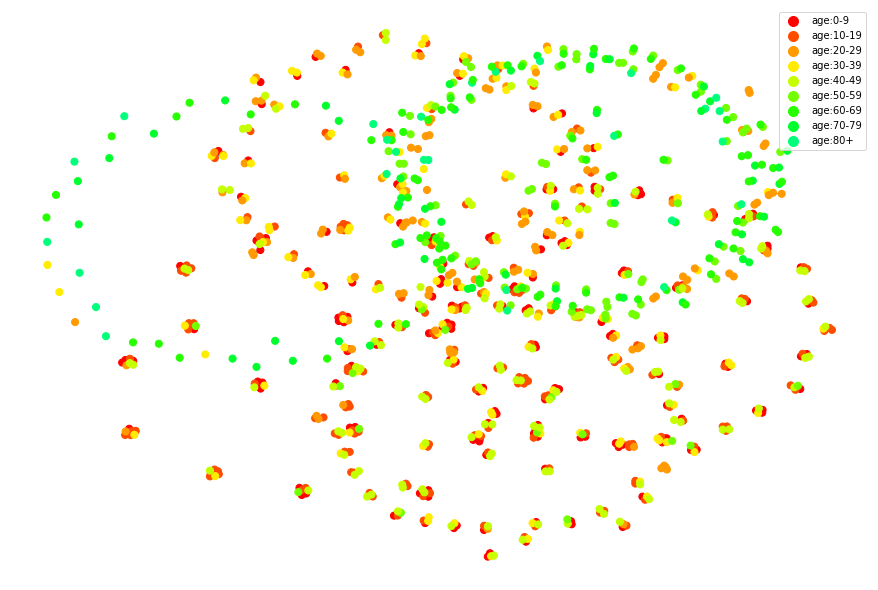

In [24]:
plt.rcParams["figure.figsize"] = (12, 8)
# pos = community_layout(g_base, situation_with_indexes)
colors = get_cmap(20)
node_colors = [colors[i] for i in age_with_indexes.values()]
# # nx.draw(g_base, pos, node_color=list(age_with_indexes.values()), node_size=50, width=0.1)
# nx.draw(g_base, pos, node_color=node_colors, node_size=50, width=0.1)

# # make empty plot with correct color and label for each group
# for i, a in enumerate(unique_ages):
#     plt.scatter([],[], c=np.array(colors[i]).reshape(1,-1), label=f'age:{a}')
# plt.legend()
g_q = demographic_graphs['distancingScale0.01']
pos = community_layout(g_q, house_size)
# colors = get_cmap(20)
# node_colors = [colors[i] for i in age_with_indexes.values()]
# plt.figure()
# nx.draw(g_base, pos, node_color=list(age_with_indexes.values()), node_size=50, width=0.1)
nx.draw(g_q, pos, node_color=node_colors, node_size=50, width=0.5)

# make empty plot with correct color and label for each group
for i, a in enumerate(unique_ages):
    plt.scatter([],[], c=np.array(colors[i]).reshape(1,-1), label=f'age:{a}')
plt.legend()

In [ ]:
nodes = []
edges = []
for h in households:
    h_nodes = []
    for i in h['indices']:
        h_nodes.append(i)
    for n1 in h_nodes:
        for n2 in h_nodes:
            if n1 != n2:  
                edges.append((n1, n2))

In [ ]:
# --- Begin_myhack ---
# All this code should replace original `pos=nx.spring_layout(graph)`
colors = 
pos = nx.circular_layout(g_base)   # replaces your original pos=...
# prep center points (along circle perimeter) for the clusters
angs = np.linspace(0, 2*np.pi, 1+len(colors))
repos = []
rad = 3.5     # radius of circle
for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
for ea in pos.keys():
    #color = 'black'
    posx = 0
    if ea in nodes_by_color['green']:
        #color = 'green'
        posx = 0
    elif ea in nodes_by_color['royalblue']:
        #color = 'royalblue'
        posx = 1
    elif ea in nodes_by_color['red']:
        #color = 'red'
        posx = 2
    elif ea in nodes_by_color['orange']:
        #color = 'orange'
        posx = 3
    elif ea in nodes_by_color['cyan']:
        #color = 'cyan'
        posx = 4
    else:
        pass
    #print(ea, pos[ea], pos[ea]+repos[posx], color, posx)
    pos[ea] += repos[posx]

In [ ]:
# Random string generator
def rand_string(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))


# Set up a nodes and networks randomly
nodes = [rand_string() for _ in range(30)]
networks = [rand_string() for _ in range(5)]
networks_list = networks*6
random.shuffle(networks_list)

# Define what nodes belong to what network and what their color should be
node_network_map = dict(zip(nodes, networks_list))
colors = ['green', 'royalblue', 'red', 'orange', 'cyan']
color_map = dict(zip(networks, colors))

graph = nx.Graph()
graph.add_nodes_from(nodes)
nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
                  for val in colors}

# Take random sparse matrix as adjacency matrix
mat = sparse_random(30, 30, density=0.3).todense()
for row, row_val in enumerate(nodes):
    for col, col_val in enumerate(nodes):
        if col > row and mat[row, col] != 0.0: # Stick to upper half triangle, mat is not symmetric
            graph.add_edge(row_val, col_val, weight=mat[row, col])

# Choose a layout to visualize graph
pos = nx.spring_layout(graph)
edges = graph.edges()

# Get the edge weights and normalize them 
weights = [abs(graph[u][v]['weight']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

# First draw the nodes 
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=node_names, node_color=color)

# Then draw edges with thickness defined by weights_n
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()

# graph = nx.Graph()
# graph.add_nodes_from(nodes)
# nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
#                   for val in colors}

In [ ]:
# --- Begin_myhack ---
# All this code should replace original `pos=nx.spring_layout(graph)`
pos = nx.circular_layout(graph)   # replaces your original pos=...
# prep center points (along circle perimeter) for the clusters
angs = np.linspace(0, 2*np.pi, 1+len(colors))
repos = []
rad = 3.5     # radius of circle
for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
for ea in pos.keys():
    #color = 'black'
    posx = 0
    if ea in nodes_by_color['green']:
        #color = 'green'
        posx = 0
    elif ea in nodes_by_color['royalblue']:
        #color = 'royalblue'
        posx = 1
    elif ea in nodes_by_color['red']:
        #color = 'red'
        posx = 2
    elif ea in nodes_by_color['orange']:
        #color = 'orange'
        posx = 3
    elif ea in nodes_by_color['cyan']:
        #color = 'cyan'
        posx = 4
    else:
        pass
    #print(ea, pos[ea], pos[ea]+repos[posx], color, posx)
    pos[ea] += repos[posx]
# --- End_myhack----

# First draw the nodes 
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=node_names, node_color=color)

# Then draw edges with thickness defined by weights_n
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()




In [31]:
age_order = ['80+', '70-79', '60-69', '50-59', '40-49', '30-39', '20-29', '10-19', '0-9']
# individual_ageGroups

In [38]:
unique, counts = numpy.unique(individual_ageGroups, return_counts=True)
dict(zip(unique, counts))


{'0-9': 173,
 '10-19': 174,
 '20-29': 147,
 '30-39': 120,
 '40-49': 129,
 '50-59': 93,
 '60-69': 87,
 '70-79': 50,
 '80+': 27}

In [33]:
age_indexes = range(len(age_order))
ages_to_indexes = {k: v for (k, v) in zip(age_order, age_indexes)}
individual_rank = [ages_to_indexes[a] for a in individual_ageGroups]

In [94]:
def create_vaccination_df(N, total_vacc_per_day_df, individual_ages_list, vacc_policy='old_to_young'):
    total_vacc_per_day = total_vacc_per_day_df.num_tot * N / (9*10**6)
    unique, counts = np.unique(individual_ages_list, return_counts=True)
    num_per_age = dict(zip(unique, counts))
    age_index = {k: i for i, k in enumerate(np.unique(individual_ages_list))}
    if vacc_policy == "old_to_young":
        # start with oldest people and go down
        age_order = ['80+', '70-79', '60-69', '50-59', '40-49', '30-39', '20-29', '10-19'][::-1]
        num_vacc_per_day = np.zeros(shape=(total_vacc_per_day.size, len(unique)))
        current_age = age_order.pop()
        for i_d, t in enumerate(total_vacc_per_day_df.num_tot):
            while (t > 0) and len(age_order) > 0:
                if num_per_age[current_age] > 0:
                    num_vacc = np.min([t, num_per_age[current_age]])
#                     print(f"t:{t}, num_vacc:{num_vacc}, len age order:{len(age_order)}")
                    num_per_age[current_age] = num_per_age[current_age] - num_vacc
                    num_vacc_per_day[i_d, age_index[current_age]] = num_vacc
                    t = t - num_vacc
                    if t > 0:
#                         print(f"finished age:{current_age}")
                        current_age = age_order.pop()
    else:
        num_vacc_per_day = total_vacc_per_day_df.iloc()[:, 1:-1].copy()
    total_vacc_per_day_df.iloc()[:, 2:2+8] = num_vacc_per_day[:, :-1]
    return total_vacc_per_day_df

In [95]:
total_vacc_per_day_df = pd.read_csv("all_new_vaccination_data.csv")
N = len(individual_ageGroups)
total_vacc_per_day_df.num_tot = (total_vacc_per_day_df.num_tot * N / (9e6)).astype(int)
data_to_vacc = create_vaccination_df(N, total_vacc_per_day_df, individual_ageGroups, vacc_policy='old_to_young')